## Import Libraries

In [20]:
import tensorflow as tf
import json
import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

## Data Preprocessing

### Load train JSON

In [21]:
train_json = 'data/al5083/train/train.json'
with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

train_data_json

{'170906-113317-Al 2mm-part3/frame_00647.png': 1,
 '170906-113317-Al 2mm-part3/frame_00672.png': 1,
 '170906-113317-Al 2mm-part3/frame_00677.png': 1,
 '170906-113317-Al 2mm-part3/frame_00646.png': 1,
 '170906-113317-Al 2mm-part3/frame_00691.png': 1,
 '170906-113317-Al 2mm-part3/frame_00684.png': 1,
 '170906-113317-Al 2mm-part3/frame_00665.png': 1,
 '170906-113317-Al 2mm-part3/frame_00668.png': 1,
 '170906-113317-Al 2mm-part3/frame_00651.png': 1,
 '170906-113317-Al 2mm-part3/frame_00655.png': 1,
 '170906-113317-Al 2mm-part3/frame_00657.png': 1,
 '170906-113317-Al 2mm-part3/frame_00687.png': 1,
 '170906-113317-Al 2mm-part3/frame_00654.png': 1,
 '170906-113317-Al 2mm-part3/frame_00676.png': 1,
 '170906-113317-Al 2mm-part3/frame_00688.png': 1,
 '170906-113317-Al 2mm-part3/frame_00674.png': 1,
 '170906-113317-Al 2mm-part3/frame_00649.png': 1,
 '170906-113317-Al 2mm-part3/frame_00693.png': 1,
 '170906-113317-Al 2mm-part3/frame_00643.png': 1,
 '170906-113317-Al 2mm-part3/frame_00662.png': 1,


### Categorize data

In [22]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)

### Count labels

In [23]:
label_counts = [0, 0, 0, 0, 0, 0]
for _, label in train_data_json.items():
    label_counts[label] += 1

label_counts 

[8758, 1783, 6325, 4028, 2953, 2819]

### Load data training

In [24]:
def load_data(path, IMG_RESIZE, dataJSON):
    all_data = []
    folders = os.listdir(path)
    
    label_counting = [0, 0, 0, 0, 0, 0]

    for folder in tqdm(folders, desc="Folders"):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            img_files = os.listdir(folder_path)
            
            for img_file in tqdm(img_files, desc=f"Processing {folder}", leave=False):
                img_path = os.path.join(folder_path, img_file)

                id_img_file_key = folder + "/" + img_file
                label = dataJSON[id_img_file_key]

                if label_counting[label] > 500: 
                    continue

                label_counting[label] += 1

                img = Image.open(img_path).resize(IMG_RESIZE)
                # img = Image.open(img_path)
                img = tf.convert_to_tensor(img)
                all_data.append((img, one_hot_encoding[label]))
    
    print("Total data: {}, Label Counts: {}".format(len(all_data), label_counting))
    return all_data

In [25]:
training_path = "data/al5083/train"
IMG_RESIZE = (256, 256)
all_data_training = load_data(path=training_path, IMG_RESIZE=IMG_RESIZE, dataJSON=train_data_json)

Folders: 100%|██████████| 47/47 [00:22<00:00,  2.06it/s]

Total data: 3006, Label Counts: [501, 501, 501, 501, 501, 501]


In [26]:
random.shuffle(all_data_training)

In [27]:
X = []
y = []
for data in all_data_training:
    X.append(data[0])
    y.append(data[1])

In [28]:
rand_num = np.random.randint(low = 0, high = len(all_data_training))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[ 0,  0,  0, ..., 13, 14, 16],
        [ 0,  0,  0, ..., 15, 15, 16],
        [ 0,  0,  0, ..., 15, 15, 16],
        ...,
        [39, 39, 39, ..., 54, 52, 53],
        [38, 39, 39, ..., 53, 52, 53],
        [38, 39, 39, ..., 53, 52, 52]], dtype=uint8)>,
 array([0., 1., 0., 0., 0., 0.]))

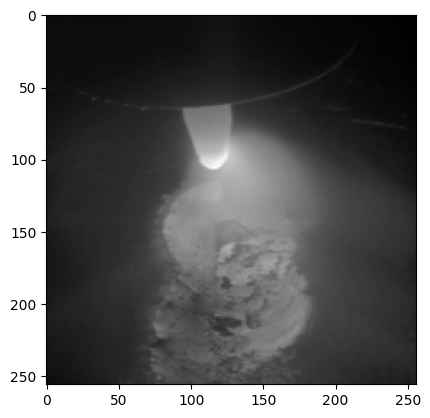

Label : contamination


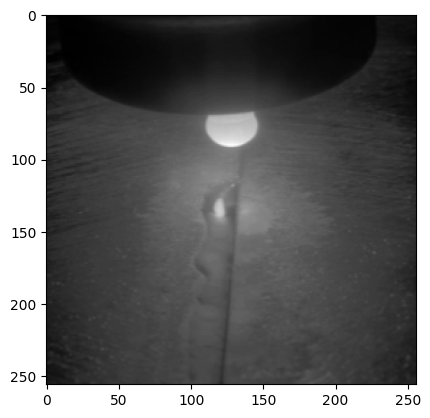

Label : lack of fusion


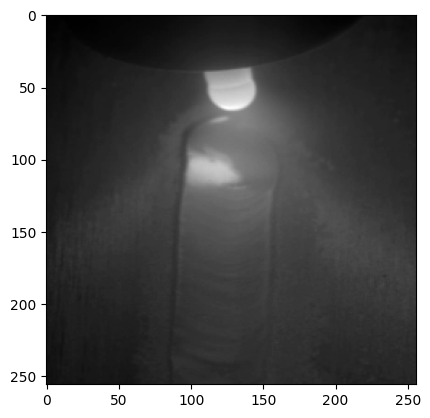

Label : good weld


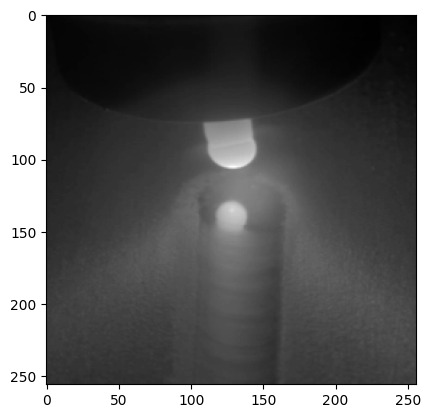

Label : lack of penetration


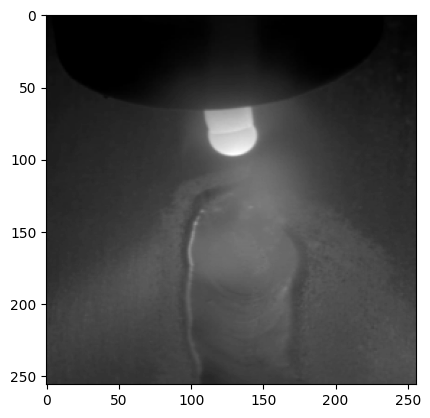

Label : good weld


In [29]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[np.argmax(y[rand_img])]}")

### Split training set to 80% traing and 20% test

In [30]:
len_data = len(X)
X_train, y_train = X[:int(len_data*0.8)], y[:int(len_data*0.8)]
X_test, y_test = X[int(len_data*0.8):], y[int(len_data*0.8):]

In [31]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([2404, 256, 256]),
 TensorShape([2404, 6]),
 TensorShape([602, 256, 256]),
 TensorShape([602, 6]))

In [33]:
X_train = tf.reshape(X_train, shape=(len(X_train), IMG_RESIZE[0], IMG_RESIZE[1], 1))
X_test = tf.reshape(X_test, shape=(len(X_test), IMG_RESIZE[0], IMG_RESIZE[1], 1))

X_train.shape, y_train.shape

(TensorShape([2404, 256, 256, 1]), TensorShape([2404, 6]))

In [34]:
class Model(tf.keras.Model):
    def __init__(self, IMG_SIZE, num_labels):
        super().__init__()
        self.conv_1 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
        self.max_pool_1 = tf.keras.layers.MaxPooling2D((2, 2))
        
        self.conv_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.max_pool_2 = tf.keras.layers.MaxPooling2D((2, 2))

        self.conv_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.max_pool_3 = tf.keras.layers.MaxPooling2D((2, 2))

        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(128, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, input):
        x = self.conv_1(input)
        x = self.max_pool_1(x)
        
        x = self.conv_2(x)
        x = self.max_pool_2(x)

        x = self.conv_3(x)
        x = self.max_pool_3(x)

        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)

        return output

In [35]:
model = Model(IMG_SIZE=IMG_RESIZE, num_labels=6)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [36]:
print(f"Train dataset Size : {len(X_train)}\nTest Dataset size : {len(X_test)}")

Train dataset Size : 2404
Test Dataset size : 602


In [37]:
# Ensure the directory exists
save_dir = './models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir, 'model.weights.h5'),
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [38]:
model.fit(x=X_train, y=y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5658 - loss: 1.6650
Epoch 1: val_accuracy improved from -inf to 0.99668, saving model to ./models\model.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.5686 - loss: 1.6540 - val_accuracy: 0.9967 - val_loss: 0.1661
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9820 - loss: 0.1297
Epoch 2: val_accuracy did not improve from 0.99668
76/76 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.9821 - loss: 0.1293 - val_accuracy: 0.9817 - val_loss: 0.0585
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9943 - loss: 0.0385
Epoch 3: val_accuracy improved from 0.99668 to 1.00000, saving model to ./models\model.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.9944 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.0212
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9979 - loss: 0.0218
Epoch 4: val_accuracy did not improve from 1.00000
76/76 ━━━━━━━━━━━━━━━━━━━━ 28

In [42]:
save_dir = './models'
weights_path = os.path.join(save_dir, 'model.weights.h5')
model.load_weights(weights_path)

In [43]:
train_metric = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss : {train_metric[0]} , Training Accuracy : {train_metric[1]}")

Training Loss : 0.023571684956550598 , Training Accuracy : 0.9995840191841125


In [44]:
test_metric = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss : {test_metric[0]} , Testing Accuracy : {test_metric[1]}")

Testing Loss : 0.0212023314088583 , Testing Accuracy : 1.0


## Quantum Classification